## Header

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

from functools import partial

from utils.multi_processing_functions import *

from utils.transition_matrix import *

PLOT_PATH = './plots_grasp_aligned_fixations_final/'
PROCESSED_DATA_PATH = '../processed_data/EIH_1/'

sns.set(
    context="talk",
    style="ticks",
    palette="muted",
    rc={'font.weight':'light'}    
)

In [2]:
import multiprocessing as mp

def pandas_mp_apply(grouped_df, apply_func):
    with mp.Pool(mp.cpu_count() - 1) as p:
        ret_list = p.map(apply_func, [(group, name) for name, group in grouped_df])
    
    return pd.concat(ret_list)

In [3]:
sns.set(
    context="talk",
    style="ticks",
    palette="muted",
    rc={'font.weight':'light'}    
)
scpt = sns.color_palette()

## Read data file

In [19]:
samples_df = pd.read_csv(
    '../processed_data/EIH_1/06_ET_cleaned.csv',
    parse_dates = ['timestamp_dt'],
    dtype = {
        'is_fixation': np.bool, 'grasp_onset_bool': np.bool,'grasp_end_bool': np.bool,
#         'subjectID': 'int32', 'trial_num': 'int32', 'trialID': 'int32',
    },
    index_col=False,
)
samples_df.head()

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


,subject_id,trial_num,trial_type,timestamp_dt,is_fixation,eye_hit,grasp,grasp_onset_bool,eye_shelf_hit,fix_duration,grasp_end_bool,grasp_duration,is_outlier_fixation,pickup_location,drop_location
0,2006.0,2.0,hard,1970-01-01 00:00:00.351460844,True,Other,NaN,False,2_4,0.122589,False,0.0,False,NaN,NaN
1,2006.0,2.0,hard,1970-01-01 00:00:00.360775739,True,Other,NaN,False,2_4,0.122589,False,0.0,False,NaN,NaN
2,2006.0,2.0,hard,1970-01-01 00:00:00.371934354,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN
3,2006.0,2.0,hard,1970-01-01 00:00:00.383572042,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN
4,2006.0,2.0,hard,1970-01-01 00:00:00.394215554,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN


In [5]:
samples_df.shape

(6757742, 15)

In [6]:
samples_df.head()

,subject_id,trial_num,trial_type,timestamp_dt,is_fixation,eye_hit,grasp,grasp_onset_bool,eye_shelf_hit,fix_duration,grasp_end_bool,grasp_duration,is_outlier_fixation,pickup_location,drop_location
0,2006.0,2.0,hard,1970-01-01 00:00:00.351460844,True,Other,NaN,False,2_4,0.122589,False,0.0,False,NaN,NaN
1,2006.0,2.0,hard,1970-01-01 00:00:00.360775739,True,Other,NaN,False,2_4,0.122589,False,0.0,False,NaN,NaN
2,2006.0,2.0,hard,1970-01-01 00:00:00.371934354,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN
3,2006.0,2.0,hard,1970-01-01 00:00:00.383572042,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN
4,2006.0,2.0,hard,1970-01-01 00:00:00.394215554,False,Other,NaN,False,2_4,0.077499,False,0.0,False,NaN,NaN


In [7]:
samples_df.columns

Index(['subject_id', 'trial_num', 'trial_type', 'timestamp_dt', 'is_fixation',
       'eye_hit', 'grasp', 'grasp_onset_bool', 'eye_shelf_hit', 'fix_duration',
       'grasp_end_bool', 'grasp_duration', 'is_outlier_fixation',
       'pickup_location', 'drop_location'],
      dtype='object')

In [26]:
samples_df.eye_hit.unique()

array(['Other', 'Cylinder_Yellow', 'Tetraeder_Yellow', 'Cylinder_Blue',
       'Tetraeder_Blue', 'Tetraeder_Green', 'Cylinder_Red',
       'Tetraeder_Red', 'Cube_Green', 'Cube_Yellow', 'Cube_Blue',
       'Sphere_Green', 'Sphere_Red', 'Cylinder_Green', 'Cube_Red',
       'Sphere_Yellow', 'Sphere_Blue', nan], dtype=object)

# Transition matrices

## Transition of fixations during action execution

In [7]:
offset = 0.

valid_objs = [
    'Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow', 
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow'
]

shelf_dict = {
    k:v 
    for k,v in 
    zip(
        sorted(samples_df.query('eye_shelf_hit!="ERROR"').eye_shelf_hit.dropna().unique()), 
        np.arange(0,25)
       )
}

shelf_locs = list(shelf_dict.keys())

#number of subjects the mp can handle
subjects = samples_df.subject_id.unique()

grp_cols = ['subject_id', 'trial_num', 'trial_type']
eye_execution_df = (
    pandas_mp_apply(
        samples_df
        .reset_index()
        .groupby(grp_cols),
        partial(eye_transitions_execution, valid_objs=valid_objs, shelf_locs=shelf_locs, offset=offset)
    )
)
display(eye_execution_df.head())
eye_execution_df = eye_execution_df.reset_index()

eye_execution_df.to_csv(f'{PROCESSED_DATA_PATH}/eye_execution_fixations.csv', index=False)

In [11]:
eye_execution_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/eye_execution_fixations.csv')

In [12]:
sym_execution_df = pd.DataFrame()
transition_exe_df = pd.DataFrame()

for subject_id in eye_execution_df.subject_id.unique():
    tm_df = eye_execution_df.query('subject_id == @subject_id')
    PLOT_PATH_transition = f'./transit_final/execution/{int(subject_id)}/'
    
    sym_dict, df = plot_net_transition_per_trial_per_grasp(tm_df, PLOT_PATH_transition, plot=False)
    
    tmpdf = pd.DataFrame.from_dict(sym_dict)
    tmpdf['subject_id'] = subject_id
    
    df['subject_id'] = subject_id
    sym_execution_df = pd.concat([sym_execution_df, tmpdf], ignore_index=True)
    transition_exe_df = pd.concat([transition_exe_df, df], ignore_index=True)

display(sym_execution_df.head())
display(transition_exe_df.head())

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
D:\projects\ErgoVR\code\utils\transition_matrix.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ori_net_transition'] = df.groupby('origin').net_transition.transform('sum')
D:\projects\ErgoVR\code\utils\transition_matrix.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,trial_num,grasp_num,sym_index,trial_type,entropy,subject_id
0,2.0,1,0.000000,hard,0,2006.0
1,2.0,2,0.666667,hard,0,2006.0
2,2.0,3,0.333333,hard,0,2006.0
3,2.0,4,1.000000,hard,0,2006.0
4,2.0,5,0.666667,hard,0,2006.0


,origin,destination,net_transition,total_transition,num_switch,trial_num,trial_type,grasp_num,ori_net_transition,rel_transition,subject_id
0,prev_TS,prev_TO,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0
1,current_TO,prev_TO,0.0,2.0,1.0,2.0,hard,1,0.0,NaN,2006.0
2,current_TO,prev_TS,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0
3,current_TS,prev_TO,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0
4,current_TS,prev_TS,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0


In [13]:
exe_df = (
    sym_execution_df
    .dropna(subset=['sym_index'])
    .groupby(['subject_id', 'trial_num', 'trial_type'])
    .agg({
        'sym_index':np.nanmean,
        'grasp_num': lambda x: x.nunique(),
    }
    )
    .reset_index()
)

In [16]:
## Chjeck correlation of median sym_index per trial  with the number of grasps per trial
tmpdf = sym_execution_df.query('trial_type=="hard"').dropna()

print(f'Hard trial:{scipy.stats.pearsonr(tmpdf.sym_index.values, tmpdf.grasp_num.values)}')

tmpdf = sym_execution_df.query('trial_type=="easy"').dropna()

print(f'Easy trial:{scipy.stats.pearsonr(tmpdf.sym_index.values, tmpdf.grasp_num.values)}')

Hard trial:(-0.14403006156538548, 0.0038048366610314447)
Easy trial:(-0.12202905646339907, 0.0032450658790575885)


### calculate T50 for the ROIs

In [13]:
t50_df = (
    eye_execution_df
    .sort_values('timestamp_dt')
#     .query('grasp_num == 10')
    .query('is_fixation == True')
    .drop_duplicates(
        subset=['subject_id', 'trial_num', 'trial_type', 'grasp_num', 
                'is_fixation', 'fix_duration', 'fix_type',], 
        keep='first') 
    .dropna(subset=['fix_type'])
    .groupby(['subject_id', 'trial_type', 'trial_num', 'grasp_num', 'fix_type'],)
    .first()
    .reset_index()
#     .agg({'time_off_grasp':['mean', 'std', 'size']})
#     .reset_index()
    
)

t50_df.head()

,subject_id,trial_type,trial_num,grasp_num,fix_type,timestamp_dt,is_fixation,eye_hit,fix_duration,time_on_grasp
0,2006.0,easy,5.0,1,current_TO,1970-01-01 00:00:08.146301270,True,Cube_Yellow,0.333126,0.164690
1,2006.0,easy,5.0,1,current_TS,1970-01-01 00:00:08.034193039,True,1_3,0.333126,0.128651
2,2006.0,easy,5.0,1,next_TO,1970-01-01 00:00:09.323147774,True,Sphere_Green,0.645035,0.543013
3,2006.0,easy,5.0,1,other,1970-01-01 00:00:07.834843636,True,Sphere_Blue,0.333126,0.064566
4,2006.0,easy,5.0,2,current_TO,1970-01-01 00:00:12.176501274,True,Sphere_Green,0.101170,0.000000


In [ ]:
t_desc = t50_df.groupby(['subject_id','trial_type','trial_num','fix_type']).size()
# display(t_desc)
t_desc = t_desc.groupby(level=[0,1,2]).apply(lambda x: x/float(x.sum())).reset_index(name='group_size')
display(t_desc)
sns.set(style='ticks', context='poster', font_scale=1)
_, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    data=t_desc,
    x='group_size',
    y='fix_type',
    hue='trial_type',
    palette=['b', 'r'],
    dodge=0.1,
    ci=99,
#     scale=0.5,
#     capsize=0.2,
    errwidth=1.5,
#     join=False,
    ax=ax    
)
ax.set(
    ylabel='Region of Interest',
    xlabel='Proportion within trial',
    xlim=(0,0.4)
)
ax.axvline(1/7., color='grey', ls=':', lw=2)
ax.legend(title='trial type', frameon=0)
sns.despine(offset=10)

plt.savefig(f'{PLOT_PATH}first_fix_roi_execution.pdf', transparent=True, bbox_inches='tight', quality=90)

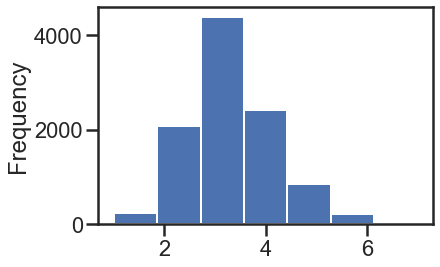

In [15]:
t = (
    t50_df
    .groupby(['subject_id', 'trial_type', 'trial_num', 'grasp_num'])
    .fix_type
    .size()
    .reset_index(name='group_size')
)
t.group_size.plot(kind='hist', bins=7);

tmp = t50_df.merge(t, on=['subject_id', 'trial_type', 'trial_num'])
tmp.query('group_size==7').shape

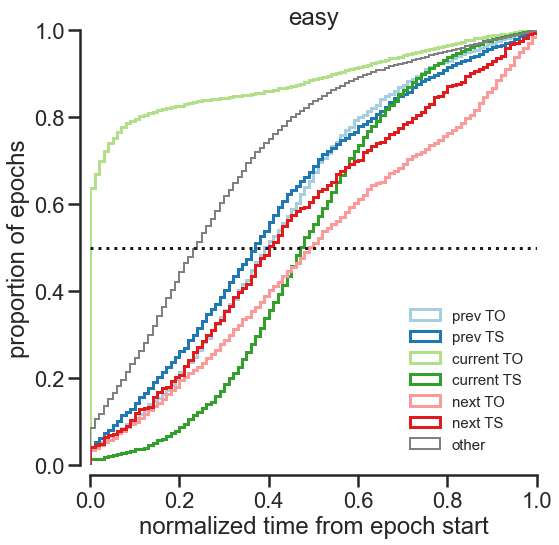

In [66]:
sns.set(context='poster', style='ticks', palette='Paired')
_, ax = plt.subplots(figsize=(8,8))
time_limit = 1.
n_bins = np.arange(0,1.3, 0.01)
trial_type='easy'

# previous TO and previous TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "prev_TO" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='prev TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('fix_type == "prev_TS" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='prev TS', ax=ax, lw=3)
)

# current TO and current TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "current_TO" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='current TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "current_TS" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='current TS', ax=ax, lw=3)
)

# next TO and next TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "next_TO" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='next TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "next_TS" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='next TS', ax=ax, lw=3)
)

ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "other" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='other', color='grey',)
)

ax.axhline(0.50, ls=':', color='k')
ax.legend(loc='lower right', fontsize=15, frameon=False)
ax.set(
    xlim=(0, 1.),
    ylim=(0,1),
    title=trial_type,
    xlabel='normalized time from epoch start',
    ylabel='proportion of epochs'
    
)
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}t50_{trial_type}_execution.pdf', transparent=True, bbox_inches='tight', quality=90)

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


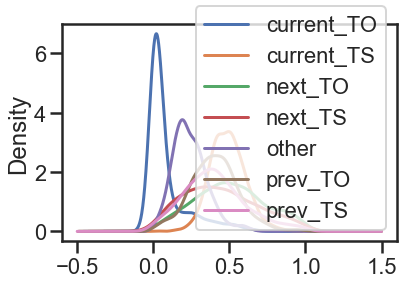

In [17]:
t = (
    t50_df
    .groupby(['subject_id', 'trial_type', 'trial_num', 'fix_type'])
    .time_on_grasp
    .apply(lambda x: np.quantile(x, 0.5))
    .reset_index(name='t50')
    
)
t['inv_time'] = 1/(t.t50)
t['log_time'] = np.log(t.t50)

t = t[t.t50 != 0 ]

t.to_csv('t50_execution.csv')
t.groupby('fix_type').t50.plot(kind='kde', legend=True);

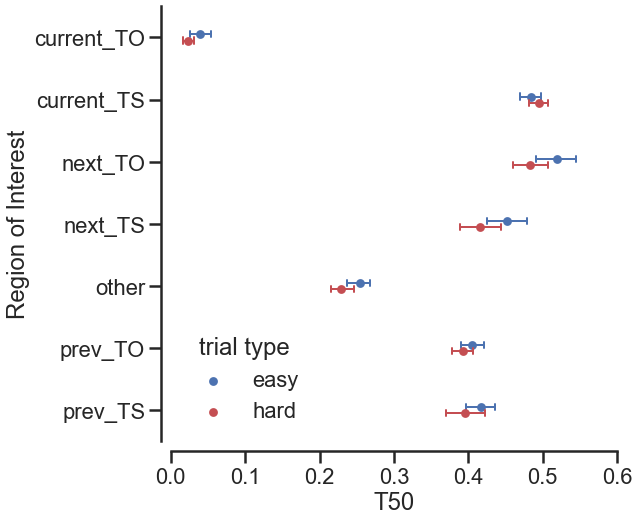

In [26]:
sns.set(style='ticks', context='poster', font_scale=1)
_, ax = plt.subplots(figsize=(8, 8))
t = (
    t
    .groupby(['subject_id', 'trial_type', 'fix_type'])
    .t50
    .mean()
    .reset_index()
    
)

ax = sns.pointplot(
    data=t,
    y='fix_type', 
    order=['current_TO', 'current_TS', 'next_TO', 'next_TS',  'other', 'prev_TO', 'prev_TS', ],
    x='t50',
    hue='trial_type',
    palette=['b', 'r'],
    dodge=0.1,
    ci=95,
    scale=0.5,
    capsize=0.1,
    errwidth=2,
    join=False,
    fillstype='none',
    ax=ax
)
ax.set(
    xlim=(0,0.6),
    xlabel='T50',
    ylabel='Region of Interest'
)
ax.legend(frameon=0, title='trial type', loc='best')
sns.despine(offset=10)

plt.savefig(f'{PLOT_PATH}t50_subject_execution.pdf', transparent=True, bbox_inches='tight', quality=90)

## Transition of fixations between end of previous grasp and start of current grasp

In [21]:
offset = 0.

valid_objs = [
    'Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow', 
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow'
]

shelf_dict = {
    k:v 
    for k,v in 
    zip(
        sorted(samples_df.query('eye_shelf_hit!="ERROR"').eye_shelf_hit.dropna().unique()), 
        np.arange(0,25)
       )
}

shelf_locs = list(shelf_dict.keys())

#number of subjects the mp can handle
subjects = samples_df.subject_id.unique()[:2]
display(subjects)
grp_cols = ['subject_id', 'trial_num', 'trial_type']
eye_planning_df = (
    pandas_mp_apply(
        samples_df
#         .query('subject_id in @subjects')
        .reset_index()
        .groupby(grp_cols),
        partial(eye_transitions_planning, valid_objs=valid_objs, shelf_locs=shelf_locs, offset=offset)
    )
)
display(eye_planning_df.head())

eye_planning_df = eye_planning_df.reset_index()

eye_planning_df.to_csv(f'{PROCESSED_DATA_PATH}/eye_planning_fixations.csv', index=False)

In [6]:
eye_planning_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/eye_planning_fixations.csv')

## calculate transition matrices and symmetry indices per trial per subject

In [7]:
sym_planning_df = pd.DataFrame()
transition_plan_df = pd.DataFrame()
for subject_id in eye_planning_df.subject_id.unique():
    tm_df = eye_planning_df.query('subject_id == @subject_id')
    PLOT_PATH_transition = f'./transition_matrix_exemplar/{int(subject_id)}/'
    
    sym_dict, df = plot_net_transition_per_trial_per_grasp(tm_df, PLOT_PATH_transition, plot=False)
    
    tmpdf = pd.DataFrame.from_dict(sym_dict)
    tmpdf['subject_id'] = subject_id
    df['subject_id'] = subject_id
    sym_planning_df = pd.concat([sym_planning_df, tmpdf], ignore_index=True)
    transition_plan_df = pd.concat([transition_plan_df, df], ignore_index=True)

    
display(sym_planning_df.head())
display(transition_plan_df.head())

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
D:\projects\ErgoVR\code\utils\transition_matrix.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ori_net_transition'] = df.groupby('origin').net_transition.transform('sum')
D:\projects\ErgoVR\code\utils\transition_matrix.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,trial_num,grasp_num,sym_index,trial_type,entropy,subject_id
0,2.0,1,1.000000,hard,0,2006.0
1,2.0,2,0.600000,hard,0,2006.0
2,2.0,3,0.714286,hard,0,2006.0
3,2.0,4,NaN,hard,0,2006.0
4,2.0,5,NaN,hard,0,2006.0


,origin,destination,net_transition,total_transition,num_switch,trial_num,trial_type,grasp_num,ori_net_transition,rel_transition,subject_id
0,prev_TS,prev_TO,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0
1,current_TO,prev_TO,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0
2,current_TO,prev_TS,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0
3,current_TS,prev_TO,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0
4,current_TS,prev_TS,0.0,0.0,0.0,2.0,hard,1,0.0,NaN,2006.0


In [8]:
plan_df = (
    sym_planning_df
    .dropna(subset=['sym_index'])
    #.query('sym_index!=0')
    .groupby(['subject_id', 'trial_num', 'trial_type'])
    .agg({
        'sym_index':np.nanmean,
        'grasp_num': lambda x: x.nunique(),
    })
    .reset_index()
)

In [38]:
tmpdf = plan_df.query('trial_type=="hard"').dropna()

print(f'Hard trial:{scipy.stats.pearsonr(tmpdf.sym_index.values, tmpdf.grasp_num.values)}')

tmpdf = plan_df.query('trial_type=="easy"').dropna()

print(f'Easy trial:{scipy.stats.pearsonr(tmpdf.sym_index.values, tmpdf.grasp_num.values)}')

Hard trial:(-0.09746597267574887, 0.05027287213827855)
Easy trial:(0.2161854800340287, 1.0852206850447863e-07)


In [16]:
exe_df['epoch'] = 'execution'
plan_df['epoch'] = 'planning'

df = pd.concat([exe_df, plan_df], ignore_index=True)
df = df.query('grasp_num >= 3')
df.to_csv(f'{PROCESSED_DATA_PATH}/all_epoch_symmetry_19Jan.csv', index=False)

In [34]:
sym_planning_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/planning_epoch_symmetry.csv',)

## Regression plot for epoch_type, trial_type, num_grasp

In [17]:
df.groupby(['trial_type',]).sym_index.describe()

count      mean       std       min       25%       50%  \
epoch     trial_type                                                            
execution easy        571.0  0.641066  0.193187  0.083333  0.496964  0.633333   
          hard        404.0  0.625442  0.172625  0.142857  0.494658  0.614585   
planning  easy        573.0  0.665623  0.175792  0.111111  0.545455  0.666667   
          hard        404.0  0.618679  0.163148  0.165125  0.509894  0.621340   

                           75%  max  
epoch     trial_type                 
execution easy        0.785165  1.0  
          hard        0.763248  1.0  
planning  easy        0.793651  1.0  
          hard        0.738095  1.0

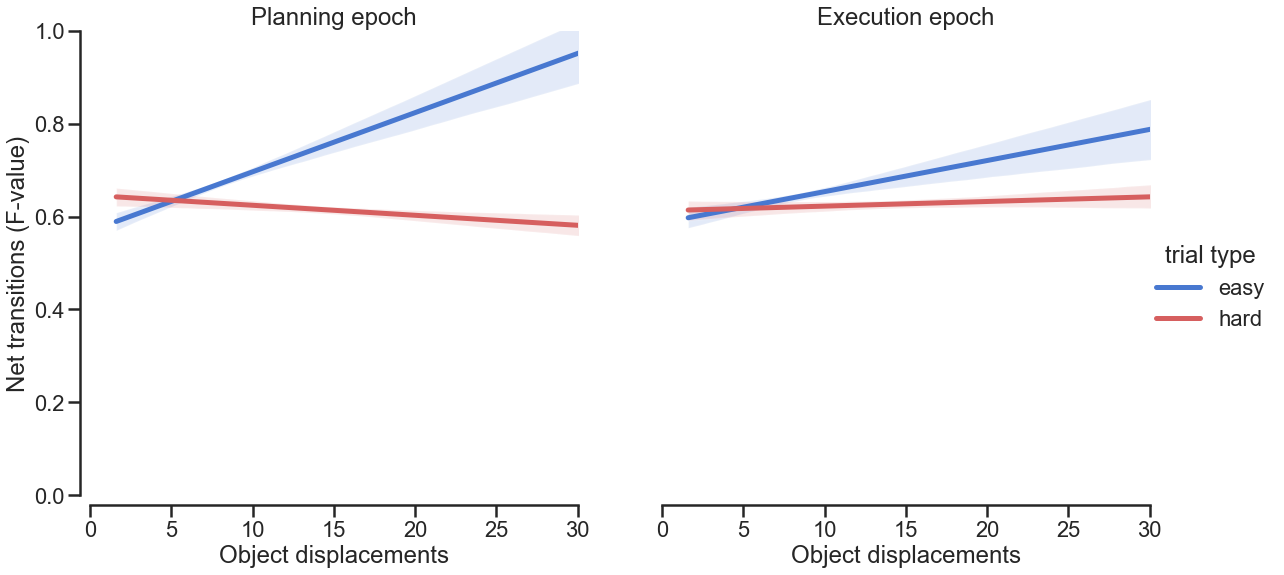

In [23]:
df = pd.read_csv(f'{PROCESSED_DATA_PATH}/all_epoch_symmetry_19Jan.csv',)

sns.set(context = "poster", style="ticks", palette="muted", rc={'figure.figsize':(15,15)})

g = sns.lmplot(
    data = df, x='grasp_num', y='sym_index', col='epoch', col_order=['planning', 'execution'],
    hue='trial_type', 
    hue_order=['easy', 'hard'], 
    fit_reg=True, ci=68, n_boot=1000,
    height=8, aspect=1, palette=['b','r'],
    scatter=False,
    #scatter_kws={"s": 100, 'edgecolors':'k', 'linewidths': 1},
    line_kws={'linewidth': 5},
    y_jitter=0.005, x_jitter=1, sharey=False, truncate=False,
)

g.set(yticks=np.arange(0,1.1,0.2), xticks=np.arange(0,31, 5))
sns.despine(offset=10)
g._legend.set_title('trial type')



i=0
for ax,title in zip(g.axes.flat,['Planning epoch', 'Execution epoch']):
    i = i+1
    ax.set(
        title=title,
        xlim=(0,30),   
        ylim = (0.,1.),
        ylabel='Net transitions (F-value)',
        xlabel='Object displacements'
    )
    
    if i == 2 :
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_ylabel('')


plt.savefig(f'{PLOT_PATH}gaze_guidance_regression.pdf', transparent=True, bbox_inches='tight')

0.6359560361724977

0.6216799032244259

0.6502321691205696

0.6410167683752473

0.6308953039697481

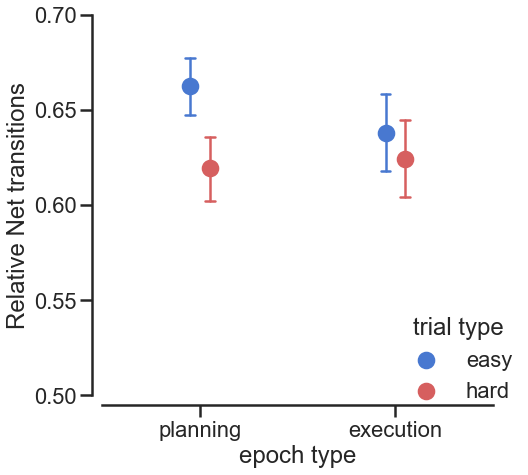

In [24]:
_, ax = plt.subplots(figsize=(7,7), sharey=True, sharex=True)
#df = pd.read_csv(f'{PROCESSED_DATA_PATH}/all_epoch_symmetry_new1.csv',)

tmpdf = df.query('grasp_num >= 3').groupby(['subject_id',  'trial_type', 'epoch',]).sym_index.mean().reset_index()
display(
    tmpdf.sym_index.mean(),  
    tmpdf.loc[tmpdf.trial_type=='hard', 'sym_index'].mean(),  
    tmpdf.loc[tmpdf.trial_type=='easy', 'sym_index'].mean(),
    tmpdf.loc[tmpdf.epoch=='planning', 'sym_index'].mean(),  
    tmpdf.loc[tmpdf.epoch=='execution', 'sym_index'].mean()
)
sns.set(context='poster', style='ticks', font_scale=1., palette='muted')


ax = sns.pointplot(
    data=tmpdf,
    x='epoch',
    y='sym_index',
    hue='trial_type',
    ci=68,
    palette=['b', 'r'],
    order = ['planning', 'execution'],
    hue_order = ['easy', 'hard'],
    dodge=0.1,   
    capsize=0.05,
    errwidth=2.5,
    join=False
)


ax.set(
    ylabel='Relative Net transitions',
    xlabel='epoch type',
    ylim=(0.50, 0.7),
    yticks=np.arange(0.5, 0.71, 0.05)
)
ax.legend(frameon=False, title='trial type', bbox_to_anchor=(1.1,0.26))
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}/mean_symindex.pdf', transparent=True, bbox_inches='tight', quality=90)

## Calculate and Plot T50 for the regions of interest

In [38]:
t50_df = (
    eye_planning_df
    .sort_values('timestamp_dt')
#     .query('grasp_num == 10')
    .query('is_fixation == True')
    .drop_duplicates(
        subset=['subject_id', 'trial_num', 'trial_type', 'grasp_num', 
                'is_fixation', 'fix_duration', 'fix_type',], 
        keep='first') 
    .dropna(subset=['fix_type'])
    .groupby(['subject_id', 'trial_type', 'trial_num', 'grasp_num', 'fix_type'],)
    .first()
#     .agg({'time_off_grasp':['mean', 'std', 'size']})
    .reset_index()
    
)


t50_df.groupby(['trial_type','fix_type']).time_off_grasp.describe()

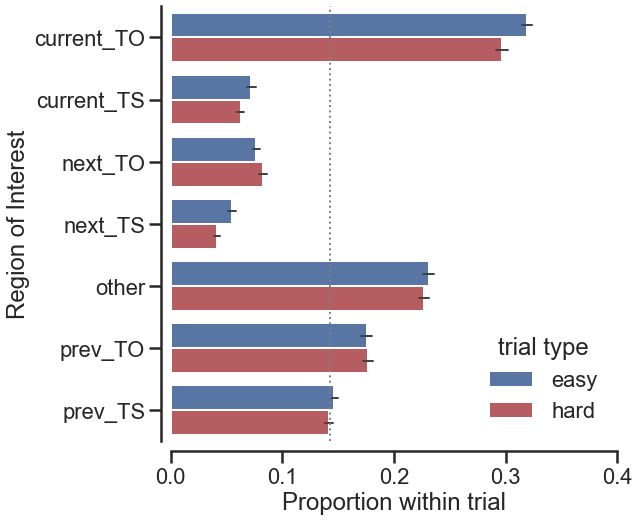

In [40]:
sns.set(style='ticks', palette='pastel')
t_desc = t50_df.groupby(['subject_id','trial_type','trial_num','fix_type']).size()
# display(t_desc)
t_desc = t_desc.groupby(level=[0,1,2]).apply(lambda x: x/float(x.sum())).reset_index(name='group_size')
# display(t_desc.head(14))
sns.set(style='ticks', context='poster', font_scale=1)
_, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    data=t_desc,
    x='group_size',
    y='fix_type',
    hue='trial_type',
    palette=['b', 'r'],
    dodge=0.1,
    ci=95,
#     scale=0.5,
#     capsize=0.2,
    errwidth=2,
#     join=False,
    ax=ax
    
)
ax.set(
    ylabel='Region of Interest',
    xlabel='Proportion within trial',
    xlim=(0,0.4)
)

ax.axvline(1/7., ls=':', lw=2, color='grey')
ax.legend(title='trial type', frameon=0)
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}first_fix_roi_planning.pdf', transparent=True, bbox_inches='tight', quality=90)

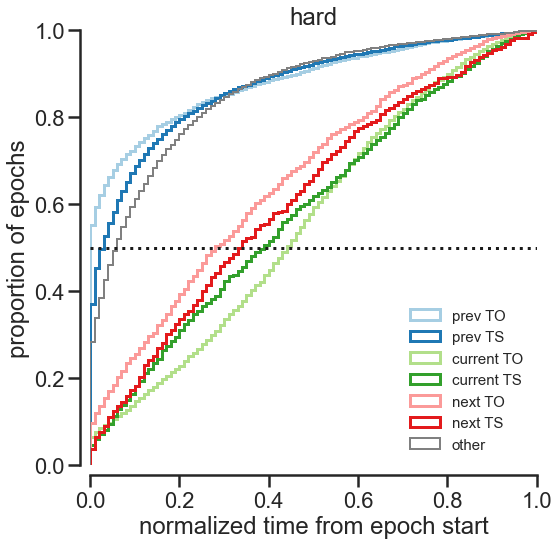

In [41]:
sns.set(context='poster', style='ticks', palette='Paired')
_, ax = plt.subplots(figsize=(8,8))
time_limit = 1
n_bins = np.arange(0, 1.3, 0.01)
trial_type='hard'

# previous TO and previous TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "prev_TO" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='prev TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('fix_type == "prev_TS" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='prev TS', ax=ax, lw=3)
)

# current TO and current TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "current_TO" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='current TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "current_TS" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='current TS', ax=ax, lw=3)
)

# next TO and next TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "next_TO" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='next TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "next_TS" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='next TS', ax=ax, lw=3)
)
# ax = (
#     t50_df
#     .query('trial_type==@trial_type and fix_type == "same_feature" and time_off_grasp <=@time_limit')
#     .time_off_grasp
#     .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='same_feature',ls="--")
# )
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "other" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='other', color='grey',)
)

ax.axhline(0.50, ls=':', color='k')
ax.legend(loc='lower right', fontsize=15, frameon=False)
ax.set(
    xlim=(0, 1.),
    ylim=(0,1),
    title=trial_type,
    xlabel='normalized time from epoch start',
    ylabel='proportion of epochs'
    
)
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}t50_{trial_type}_planning.pdf', transparent=True, bbox_inches='tight', quality=90)

In [ ]:
t = (
    t50_df
    .groupby(['subject_id', 'trial_type', 'trial_num', 'fix_type'])
    .time_off_grasp
    .apply(lambda x: np.quantile(x, 0.5))
    .reset_index(name='t50')
    
)
t['inv_time'] = 1/(t.t50)
t['log_time'] = np.log(t.t50)

t = t[t.t50 != 0 ]

t.to_csv('t50_planning.csv')
t.groupby('fix_type').t50.plot(kind='kde', legend=True);

In [97]:
easy_cto = t.query('trial_type=="easy" and fix_type=="current_TO"').t50.values
easy_other = t.query('trial_type=="easy" and fix_type=="current_TS"').t50.values
print(scipy.stats.ttest_ind(easy_cto, easy_other))

hard_cto = t.query('trial_type=="hard" and fix_type=="current_TO"').t50.values
hard_other = t.query('trial_type=="hard" and fix_type=="current_TS"').t50.values
print(scipy.stats.ttest_ind(hard_cto, hard_other))

Ttest_indResult(statistic=4.238940358649393, pvalue=2.4508227531225662e-05)
Ttest_indResult(statistic=3.9514273663041224, pvalue=8.500256175796517e-05)


In [ ]:

print(g.axes_dict.items())
for order, ax in g.axes_dict.items():
    for subject_id in t.subject_id.unique():
        tmp = t.query('subject_id==@subject_id and fix_type==@order')
        if tmp.shape[0]>5:
            #display(tmp)
            sns.kdeplot(
                data=tmp, x='t50', 
                hue='trial_type', hue_order=['easy', 'hard'], lw=1, alpha=0.5, clip_on=False,
                palette=[pal[0], pal[4]], fill=False,
                ax=ax
            )

# Median time to first fixations

## Execution Epoch

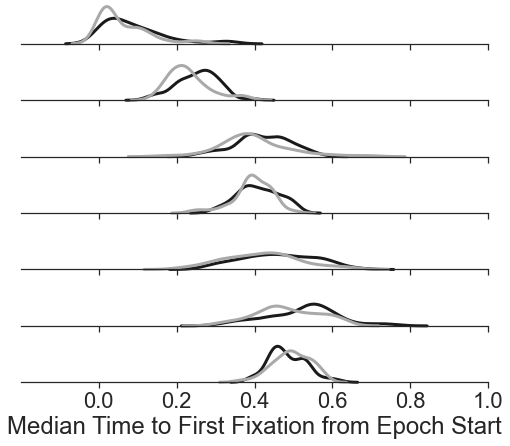

In [88]:
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0),}, font_scale=2)
t = pd.read_csv('./t50_execution.csv')
tmp = (t.groupby(['subject_id', 'fix_type', 'trial_type']).t50.mean().reset_index())
# pal = sns.cubehelix_palette(7, rot=-.25, light=.7)
pal = sns.color_palette('Paired')
order = ['current_TO', 'other', 'prev_TS', 'prev_TO', 'next_TS', 'next_TO', 'current_TS']
g = sns.FacetGrid(
    tmp, row="fix_type",
    row_order=order, hue='trial_type', 
    hue_order=['easy', 'hard'], 
    height=1., aspect=8, palette=['k', 'darkgrey'],
    xlim=(0,1)
)


g.map(sns.kdeplot, "t50", clip_on=False, fill=False, alpha=0.7, linewidth=3, bw_adjust=.8, )
def label(x, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontsize=20,
            ha="left", va="center", transform=ax.transAxes)


# g.map(label, "fix_type")

g.fig.subplots_adjust(hspace=0.7)

g.set_titles("")
g.set(
    yticks=[],
    ylim=(0,8),
    xlim=(-0.2, 1), xticks=np.arange(0, 1.1, 0.2),
    xlabel='Median Time to First Fixation from Epoch Start')

g.despine(bottom=False, left=True)
plt.savefig(f'{PLOT_PATH}t50_ridge_execution.pdf', transparent=True, bbox_inches='tight', quality=90)

## Planning Epoch

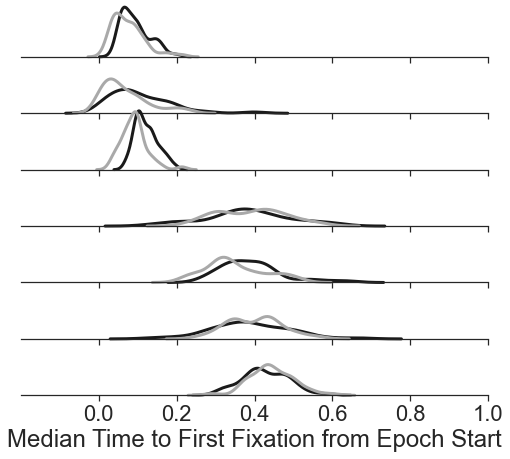

In [87]:
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0),}, font_scale=2)
t = pd.read_csv('./t50_planning.csv')
tmp = (t.groupby(['subject_id', 'fix_type', 'trial_type']).t50.mean().reset_index())
#pal = sns.cubehelix_palette(7, rot=-.25, light=.7)
#pal = sns.color_palette("Paired")
order = ['prev_TS', 'prev_TO', 'other', 'next_TS', 'next_TO', 'current_TS', 'current_TO']
g = sns.FacetGrid(
    tmp, row="fix_type",
    row_order=order, hue='trial_type', 
    hue_order=['easy', 'hard'], 
    height=1., aspect=8, palette=['k', 'darkgrey'],
    xlim=(0,1)
)


g.map(sns.kdeplot, "t50", clip_on=False, fill=False, alpha=0.7, linewidth=3, bw_adjust=.8,)

# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# g.map(sns.stripplot, "t50", alpha=0.1, size=10, edgecolor='grey', dodge=True)
# g.map(sns.pointplot, 't50', scale=3, dodge=0.5, capsize=0.2, errwidth=5,)

#g.map(sns.kdeplot, "t50", clip_on=False, color="w", lw=1, bw_adjust=0.5)

# g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, color=color, fontsize=20,
            ha="left", va="center", transform=ax.transAxes)


#g.map(label, "t50")

g.fig.subplots_adjust(hspace=0.7)

g.set_titles("")
g.set(
    yticks=[],
    ylim=(0,8),
    xlim=(-0.2, 1), xticks=np.arange(0, 1.1, 0.2),
    xlabel='Median Time to First Fixation from Epoch Start')

g.despine(bottom=False, left=True)
plt.savefig(f'{PLOT_PATH}t50_ridge_planning.pdf', transparent=True, bbox_inches='tight', quality=90)